SEIS763 Team Project:  Machine Learning Regression Analysis of a Thermal Asperity Detector
Team Members:
Monique Dargis
Erik Hutchinson
Connor Mills
Derek Synan

In [1]:
# Load Libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

# Loading the dataset
df=pd.read_csv("TADsampleResPF.csv")

# Correct Column Datatypes
df["WFR_CUBE_NUM"]=df.WFR_CUBE_NUM.astype(str)
df["PHOTOMASK"]=df.PHOTOMASK.astype(str)
df["ISI_TESTER"]=df.ISI_TESTER.astype(str)
df["LAP_TOOL"]=df.LAP_TOOL.astype(str)
df["HGA_PF"]=df.HGA_PF.astype(str)

# Verify the dataframe size & datatypes for the columns
print(df.shape)
print(df.dtypes)

(107432, 28)
WFR_X_UM           int64
WFR_Y_UM           int64
WFR_X_IN_CUBE      int64
WFR_Y_IN_CUBE      int64
WFR_CUBE_NUM      object
BAR_ID            object
HEAD_ID           object
WAFER_ID          object
PROD_CODE         object
PHOTO_TOOL        object
PHOTOMASK         object
OVL-Y_TOOL        object
OVL-Y_DELTA      float64
SEM_TOOL          object
SEM_DELTA        float64
PROM_TOOL         object
PROM_DELTA       float64
XRF_TOOL          object
XRF_DELTA        float64
MILL_TOOL         object
WAFER_TAD_RES    float64
ISI_TESTER        object
ESTBP            float64
ELG_SH_DELTA     float64
LAP_TOOL          object
HGA_TESTER        object
HGA_RES          float64
HGA_PF            object
dtype: object


In [2]:
# Reorder HGA_RES to front of Dataframe to make the TARGET column easy to find

hgares = df['HGA_RES']
df.drop(labels=['HGA_RES'], axis=1, inplace = True)
df.insert(0, 'HGA_RES', hgares)

# Reorder HGA_PF to front of Dataframe to make the TARGET column easy to find

hgapf = df['HGA_PF']
df.drop(labels=['HGA_PF'], axis=1, inplace = True)
df.insert(1, 'HGA_PF', hgapf)

df.head()

,HGA_RES,HGA_PF,WFR_X_UM,WFR_Y_UM,WFR_X_IN_CUBE,WFR_Y_IN_CUBE,WFR_CUBE_NUM,BAR_ID,HEAD_ID,WAFER_ID,...,PROM_DELTA,XRF_TOOL,XRF_DELTA,MILL_TOOL,WAFER_TAD_RES,ISI_TESTER,ESTBP,ELG_SH_DELTA,LAP_TOOL,HGA_TESTER
0,93.3247,1,23101,-45899,5,28,88,C0,D0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.846148,112.0,91.020,-3.955,4263.0,V3CR375A
1,90.2121,1,-2309,-84299,10,35,29,0Y,K1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,27.420664,162.0,113.205,-0.073,4263.0,V3CR375A
2,87.7450,1,-66219,49801,9,32,213,EM,X1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.870705,173.0,102.549,-1029.000,4263.0,V3CR492A
3,111.1483,0,21561,15301,7,7,183,6F,F0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,26.264261,120.0,114.428,-1029.000,4263.0,V3CR375A
4,91.6131,1,18481,51001,11,36,221,9Q,J0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.581217,132.0,93.245,-2.109,4263.0,V3CR375A


In [3]:
# Start Cleaning data

# Drop rows with missing data
df1 = df.dropna(axis=0)

# Remove Outliers

df1 = df1.drop(df1[(df1.XRF_DELTA < -10)].index)
df1 = df1.drop(df1[(df1.XRF_DELTA > 10)].index)
df1 = df1.drop(df1[(df1.WAFER_TAD_RES < 10)].index)
df1 = df1.drop(df1[(df1.WAFER_TAD_RES > 50)].index)
df1 = df1.drop(df1[(df1.ESTBP < 30)].index)
df1 = df1.drop(df1[(df1.ESTBP > 180)].index)
df1 = df1.drop(df1[(df1.ELG_SH_DELTA < -10)].index)
df1 = df1.drop(df1[(df1.ELG_SH_DELTA > 10)].index)
df1 = df1.drop(df1[(df1.HGA_RES < 50)].index)
df1 = df1.drop(df1[(df1.HGA_RES > 150)].index)

print(df1.shape)
df1.head()


(80008, 28)


,HGA_RES,HGA_PF,WFR_X_UM,WFR_Y_UM,WFR_X_IN_CUBE,WFR_Y_IN_CUBE,WFR_CUBE_NUM,BAR_ID,HEAD_ID,WAFER_ID,...,PROM_DELTA,XRF_TOOL,XRF_DELTA,MILL_TOOL,WAFER_TAD_RES,ISI_TESTER,ESTBP,ELG_SH_DELTA,LAP_TOOL,HGA_TESTER
0,93.3247,1,23101,-45899,5,28,88,C0,D0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.846148,112.0,91.020,-3.955,4263.0,V3CR375A
1,90.2121,1,-2309,-84299,10,35,29,0Y,K1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,27.420664,162.0,113.205,-0.073,4263.0,V3CR375A
4,91.6131,1,18481,51001,11,36,221,9Q,J0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.581217,132.0,93.245,-2.109,4263.0,V3CR375A
6,95.0665,1,-53129,-8699,6,17,138,KG,G1,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,26.950050,72.0,101.439,-0.201,4266.0,V3CR492A
8,90.3425,1,-34649,-37799,10,10,102,HR,I0,U8IDG,...,0.0263,XRF_54,-4.8858,NXE_51,25.913645,72.0,103.679,0.116,4266.0,V3CR492A


In [4]:
# Create Columns for Categorical Values

df1_dummies = pd.get_dummies(df1, columns=["PHOTO_TOOL"])
df2_dummies = pd.get_dummies(df1_dummies, columns=["PHOTOMASK"])
df3_dummies = pd.get_dummies(df2_dummies, columns=["OVL-Y_TOOL"])
df4_dummies = pd.get_dummies(df3_dummies, columns=["SEM_TOOL"])
df5_dummies = pd.get_dummies(df4_dummies, columns=["PROM_TOOL"])
df6_dummies = pd.get_dummies(df5_dummies, columns=["XRF_TOOL"])
df7_dummies = pd.get_dummies(df6_dummies, columns=["MILL_TOOL"])
df8_dummies = pd.get_dummies(df7_dummies, columns=["ISI_TESTER"])
df9_dummies = pd.get_dummies(df8_dummies, columns=["LAP_TOOL"])
df10_dummies = pd.get_dummies(df9_dummies, columns=["HGA_TESTER"])

print(df10_dummies.shape)
df10_dummies.head()

(80008, 400)


,HGA_RES,HGA_PF,WFR_X_UM,WFR_Y_UM,WFR_X_IN_CUBE,WFR_Y_IN_CUBE,WFR_CUBE_NUM,BAR_ID,HEAD_ID,WAFER_ID,...,HGA_TESTER_V3CR970A,HGA_TESTER_V3CR977A,HGA_TESTER_V3CR980A,HGA_TESTER_V3CR990A,HGA_TESTER_V3CR991A,HGA_TESTER_V3CR992A,HGA_TESTER_V3CR999A,HGA_TESTER_V3CRA59A,HGA_TESTER_V6CR387A,HGA_TESTER_V6CR904A
0,93.3247,1,23101,-45899,5,28,88,C0,D0,U8IDG,...,0,0,0,0,0,0,0,0,0,0
1,90.2121,1,-2309,-84299,10,35,29,0Y,K1,U8IDG,...,0,0,0,0,0,0,0,0,0,0
4,91.6131,1,18481,51001,11,36,221,9Q,J0,U8IDG,...,0,0,0,0,0,0,0,0,0,0
6,95.0665,1,-53129,-8699,6,17,138,KG,G1,U8IDG,...,0,0,0,0,0,0,0,0,0,0
8,90.3425,1,-34649,-37799,10,10,102,HR,I0,U8IDG,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Declare Independent & Dependent Variables

X = df10_dummies.iloc[:,11:400]
y1 = df10_dummies.iloc[:,0].values  # Numerical Target
y2 = df10_dummies.iloc[:,1].values  # Pass/Fail Target
X.shape

(80008, 389)

In [6]:
#Standardize X for future use
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()

In [7]:
#Splitting the data into Training Set and Test Set

from sklearn.model_selection import train_test_split
X_train, X_test, y1_train, y1_test = train_test_split(X,y1,test_size=0.3)

# Normalize the features
X_train_std = sc_X.fit_transform(X_train)
X_test_std = sc_X.transform(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


In [8]:
# Linear Regression model with all features included
from sklearn.linear_model import LinearRegression
mlrObj = LinearRegression()

mlrObj.fit(X_train_std, y1_train)

y1_pred = mlrObj.predict(X_test_std)

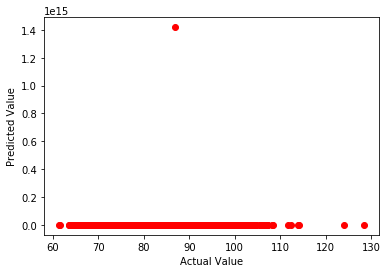

In [9]:
#VisualExploration of Testing Set

plt.scatter(y1_test,y1_pred,color='red')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, r2_score
print("R^2 score: ", r2_score(y1_pred, y1_test))
print("Mean Squared Error: ", mean_squared_error(y1_pred, y1_test))

R^2 score:  -4.166319472798108e-05
Mean Squared Error:  8.381632049002432e+25


Let's try stepwise selection to reduce the number of features included. Hopefully, this will result in a more accurate model.

In [11]:
#Reduce features based on Stepwise elimination

reduced_columns = ['ELG_SH_DELTA', 'OVL-Y_TOOL_ARC_60', 'OVL-Y_DELTA', 'SEM_TOOL_SEM_62', 'ESTBP', 'SEM_DELTA', 'WAFER_TAD_RES', 'OVL-Y_TOOL_ARC_59', 'PHOTO_TOOL_ASM_52', 'HGA_TESTER_V3CR235A', 'LAP_TOOL_4287.0', 'LAP_TOOL_4280.0', 'LAP_TOOL_4288.0', 'LAP_TOOL_4191.0', 'LAP_TOOL_4192.0', 'LAP_TOOL_4258.0', 'LAP_TOOL_4259.0', 'LAP_TOOL_4281.0', 'LAP_TOOL_4190.0', 'LAP_TOOL_4279.0', 'LAP_TOOL_4187.0', 'LAP_TOOL_4295.0', 'LAP_TOOL_4180.0', 'LAP_TOOL_4170.0', 'LAP_TOOL_4268.0', 'LAP_TOOL_4261.0', 'LAP_TOOL_4265.0', 'LAP_TOOL_4001.0', 'LAP_TOOL_4171.0', 'HGA_TESTER_V3CR817A', 'LAP_TOOL_4296.0', 'HGA_TESTER_V6CR904A', 'HGA_TESTER_V6CR387A', 'OVL-Y_TOOL_ARC_57', 'HGA_TESTER_V3CR492A', 'HGA_TESTER_V3CR330A', 'HGA_TESTER_V3CR302A', 'HGA_TESTER_V3CR886A', 'MILL_TOOL_NXE_51', 'HGA_TESTER_V3CR608A', 'HGA_TESTER_V3CR790A', 'HGA_TESTER_V3CR103A', 'ISI_TESTER_183.0', 'LAP_TOOL_4186.0', 'HGA_TESTER_V3CR473A', 'HGA_TESTER_V3CR764A', 'LAP_TOOL_4018.0', 'HGA_TESTER_V3CR301A', 'HGA_TESTER_V3CR357A', 'HGA_TESTER_V3CR759A', 'ISI_TESTER_114.0', 'HGA_TESTER_V3CR364A', 'XRF_DELTA', 'HGA_TESTER_V3CR375A', 'HGA_TESTER_V3CR670A', 'HGA_TESTER_V3CR456A', 'HGA_TESTER_V3CR907A', 'HGA_TESTER_V3CR246A', 'HGA_TESTER_V3CR521A', 'HGA_TESTER_V3CR747A', 'HGA_TESTER_V3CR776A', 'HGA_TESTER_V3CR320A', 'HGA_TESTER_V3CR525A', 'HGA_TESTER_V3CR683A', 'HGA_TESTER_V3CR822A', 'HGA_TESTER_V3CR647A', 'HGA_TESTER_V3CR236A', 'HGA_TESTER_V3CR512A', 'HGA_TESTER_V3CR727A', 'HGA_TESTER_V3CR528A', 'HGA_TESTER_V3CR185A', 'LAP_TOOL_4262.0', 'HGA_TESTER_V3CR399A', 'HGA_TESTER_V3CR642A', 'HGA_TESTER_V3CR672A', 'LAP_TOOL_4264.0', 'HGA_TESTER_V3CR930A', 'HGA_TESTER_V3CR171A', 'ISI_TESTER_84.0', 'HGA_TESTER_V3CR735A', 'HGA_TESTER_V3CR141A', 'HGA_TESTER_V3CR936A', 'OVL-Y_TOOL_ARC_55', 'HGA_TESTER_V3CR980A', 'HGA_TESTER_V3CR774A', 'HGA_TESTER_V3CR436A', 'ISI_TESTER_184.0', 'HGA_TESTER_V3CR409A', 'SEM_TOOL_SEM_69', 'HGA_TESTER_V3CR859A', 'HGA_TESTER_V3CR826A', 'HGA_TESTER_V3CR754A', 'HGA_TESTER_V3CR838A', 'HGA_TESTER_V3CR796A', 'ISI_TESTER_179.0', 'HGA_TESTER_V3CR201A', 'HGA_TESTER_V3CR697A', 'ISI_TESTER_135.0', 'HGA_TESTER_V3CR671A', 'HGA_TESTER_V3CR902A', 'HGA_TESTER_V3CR386A', 'HGA_TESTER_V3CR342A', 'HGA_TESTER_V3CR928A', 'HGA_TESTER_V3CR740A', 'HGA_TESTER_V3CR179A', 'HGA_TESTER_V3CR686A', 'HGA_TESTER_V3CR404A', 'HGA_TESTER_V3CR682A', 'HGA_TESTER_V3CR131A', 'HGA_TESTER_V3CR949A', 'HGA_TESTER_V3CR350A', 'HGA_TESTER_V3CR719A', 'HGA_TESTER_V3CR356A', 'HGA_TESTER_V3CR937A', 'HGA_TESTER_V3CR903A', 'HGA_TESTER_V3CR169A', 'HGA_TESTER_V3CR135A', 'HGA_TESTER_V3CR245A', 'HGA_TESTER_V3CR797A', 'HGA_TESTER_V3CR716A', 'HGA_TESTER_V3CR348A', 'HGA_TESTER_V3CR140A', 'HGA_TESTER_V3CR341A', 'HGA_TESTER_V3CR893A', 'HGA_TESTER_V3CR694A', 'HGA_TESTER_V3CR305A', 'HGA_TESTER_V3CR706A', 'HGA_TESTER_V3CR715A', 'HGA_TESTER_V3CR347A', 'HGA_TESTER_V3CR848A', 'HGA_TESTER_V3CR466A', 'HGA_TESTER_V3CR939A', 'HGA_TESTER_V3CR906A', 'HGA_TESTER_V3CR206A', 'ISI_TESTER_164.0', 'ISI_TESTER_129.0', 'ISI_TESTER_25.0', 'HGA_TESTER_V3CR955A', 'ISI_TESTER_113.0', 'ISI_TESTER_239.0', 'ISI_TESTER_58.0', 'LAP_TOOL_4292.0', 'LAP_TOOL_4175.0', 'LAP_TOOL_4195.0', 'LAP_TOOL_4267.0', 'HGA_TESTER_V3CR150A', 'ISI_TESTER_222.0', 'ISI_TESTER_99.0', 'HGA_TESTER_V3CR954A', 'ISI_TESTER_143.0', 'OVL-Y_TOOL_ARC_07', 'ISI_TESTER_94.0', 'ISI_TESTER_190.0', 'ISI_TESTER_176.0', 'ISI_TESTER_124.0', 'HGA_TESTER_V3CR319A', 'LAP_TOOL_4002.0', 'ISI_TESTER_251.0', 'HGA_TESTER_V3CR922A', 'ISI_TESTER_181.0', 'ISI_TESTER_130.0', 'ISI_TESTER_97.0', 'HGA_TESTER_V3CR192A', 'ISI_TESTER_46.0', 'ISI_TESTER_146.0', 'HGA_TESTER_V3CR373A', 'ISI_TESTER_228.0', 'HGA_TESTER_V3CRA59A', 'HGA_TESTER_V3CR990A', 'HGA_TESTER_V3CR635A', 'ISI_TESTER_187.0']

X_step_train = X_train[reduced_columns]
X_step_test = X_test[reduced_columns]

print(X_step_train.shape)
print(X_step_test.shape)

(56005, 171)
(24003, 171)


In [12]:
#Prep the data to fit a new Multiple Linear Regression model

# Normalize the features
X_step_train_std = sc_X.fit_transform(X_step_train)
X_step_test_std = sc_X.transform(X_step_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  """


In [13]:
mlrObj.fit(X_step_train_std, y1_train)

y1_step_pred = mlrObj.predict(X_step_test_std)

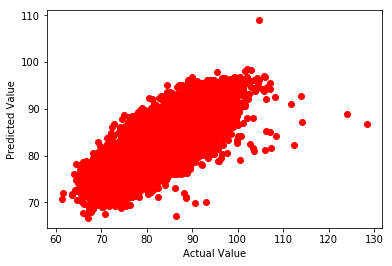

In [14]:
#VisualExploration of Testing Set

plt.scatter(y1_test,y1_step_pred,color='red')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [15]:
print("R^2 score: ", r2_score(y1_step_pred, y1_test))
print("Mean Squared Error: ", mean_squared_error(y1_step_pred, y1_test))

R^2 score:  0.48239515195433236
Mean Squared Error:  11.783323186413128


In [16]:
#Applying PCA
from sklearn.decomposition import PCA
pcaObj = PCA(n_components=None)
X_PCA_train = pcaObj.fit_transform(X_train_std)
X_PCA_test = pcaObj.transform(X_test_std)
components_variance_PCA = pcaObj.explained_variance_ratio_

In [17]:
CumSum_PCA = 0
feature_no = list(range(1,390))

print("Cumulative Variance:")
for i in range(len(components_variance_PCA)):
    CumSum_PCA = CumSum_PCA + components_variance_PCA[i]
    print(i+1, components_variance_PCA[i], CumSum_PCA)

Cumulative Variance:
1 0.023310407019914086 0.023310407019914086
2 0.014537279142903932 0.037847686162818014
3 0.009794995669737785 0.0476426818325558
4 0.00831329232249107 0.05595597415504687
5 0.00711845648800119 0.06307443064304806
6 0.006348074536823909 0.06942250517987197
7 0.00599839425092986 0.07542089943080184
8 0.005822198489897888 0.08124309792069973
9 0.005237300555140926 0.08648039847584064
10 0.0049024367967899895 0.09138283527263064
11 0.00456331312638564 0.09594614839901627
12 0.004235042596516931 0.1001811909955332
13 0.003868987646228551 0.10405017864176175
14 0.003587731703998507 0.10763791034576026
15 0.0035545729441151448 0.1111924832898754
16 0.003451807649038201 0.1146442909389136
17 0.0034350566090643685 0.11807934754797797
18 0.0033871758810090154 0.12146652342898699
19 0.003321666630458064 0.12478819005944505
20 0.003302958741294289 0.12809114880073935
21 0.00323832362700188 0.13132947242774123
22 0.003230286799158861 0.13455975922690008
23 0.003186645964036547

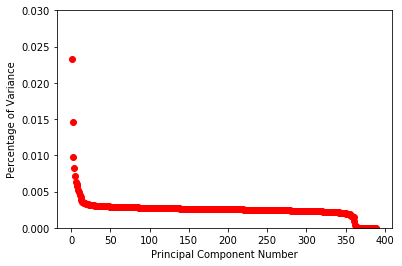

In [18]:
#Visual Exploration of Training Set

plt.scatter(feature_no,components_variance_PCA,color='red')
plt.xlabel('Principal Component Number')
plt.ylabel('Percentage of Variance')
plt.ylim(0,0.03)
plt.show()

In [19]:
#Applying PCA
pcaObj = PCA(.95) #explains 95% of the variance
X_PCA_train = pcaObj.fit_transform(X_train_std)
X_PCA_test = pcaObj.transform(X_test_std)
components_variance_PCA = pcaObj.explained_variance_ratio_

In [20]:
mlrObj.fit(X_PCA_train, y1_train)

y1_PCA_pred = mlrObj.predict(X_PCA_test)

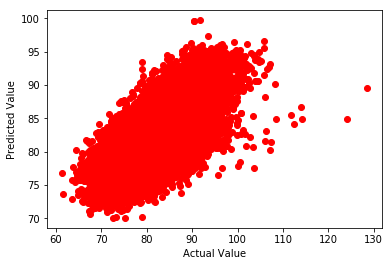

In [21]:
#VisualExploration of Testing Set

plt.scatter(y1_test,y1_PCA_pred,color='red')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

In [22]:
print("R^2 score: ", r2_score(y1_PCA_pred, y1_test))
print("Mean Squared Error: ", mean_squared_error(y1_PCA_pred, y1_test))

R^2 score:  0.004244223459644592
Mean Squared Error:  17.175625563376293
